<a href="https://colab.research.google.com/github/Jagadishchandra17/Deep-Learning-AI-capstone-project-using-pytorch/blob/main/3_1_linearclassiferPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Linear  Classifier with PyTorch </h1>


<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


In [2]:
!pip install skillsnetwork
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim
import skillsnetwork

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.1 MB/s eta 0:00:00


<h2 id="download_data">Download Data</h2>


In this section, you are going to download the data from IBM object storage using **skillsnetwork.prepare** command. <b>skillsnetwork.prepare</b> is a command that's used to download a zip file, unzip it and store it in a specified directory. Locally we store the data in the directory  **/resources/data**.


First, we download the file that contains the images:


In [4]:
import os

# Create the resources directory if it doesn't exist
if not os.path.exists("/resources"):
    os.makedirs("/resources")
await skillsnetwork.prepare("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip", path = "/resources/data", overwrite=True)

  0%|          | 0/40000 [00:00<?, ?it/s]

Saved to '../resources/data'


<h2 id="data_class">Dataset Class</h2>


In this section, we will use the previous code to build a dataset class. As before, make sure the even samples are positive, and the odd samples are negative.  In this case, if the parameter <code>train</code> is set to <code>True</code>, use the first 10 000 samples as training data; otherwise, the last 10 000 samples will be used as validation data. Do not forget to sort your files so they are in the same order.  


**Note:** We are using the first 10,000 samples as our training data instead of the available 30,000 to decrease the training time of the model. If you want, you can train it yourself with all 30,000 samples just by modifying 2 lines in the following code chunk.


In [5]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/resources/data"
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0

        if train:
            self.all_files=self.all_files[0:10000] #Change to 30000 to use the full test dataset
            self.Y=self.Y[0:10000] #Change to 30000 to use the full test dataset
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)

    # Get the length
    def __len__(self):
        return self.len

    # Getter
    def __getitem__(self, idx):


        image=Image.open(self.all_files[idx])
        y=self.Y[idx]


        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

<h2 id="trasform_Data_object">Transform Object and Dataset Object</h2>


Create a transform object, that uses the <code>Compose</code> function. First use the transform <code>ToTensor()</code> and followed by <code>Normalize(mean, std)</code>. The value for <code> mean</code> and <code>std</code> are provided for you.


In [6]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# transforms.ToTensor()
#transforms.Normalize(mean, std)
#transforms.Compose([])

transform =transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean, std)])


Create object for the training data  <code>dataset_train</code> and validation <code>dataset_val</code>. Use the transform object to convert the images to tensors using the transform object:


In [7]:
dataset_train=Dataset(transform=transform,train=True)
dataset_val=Dataset(transform=transform,train=False)

We  can find the shape of the image:


In [8]:
dataset_train[0][0].shape

torch.Size([3, 227, 227])

We see that it's a color image with three channels:


In [9]:
size_of_image=3*227*227
size_of_image

154587

## Model Training


<b>Parameter Values</b>
   <li>learning rate:0.1 </li>
   <li>momentum term:0.1 </li>
   <li>batch size training:5</li>
   <li>Loss function:Cross Entropy Loss </li>
   <li>epochs:5</li>
   <li>set: torch.manual_seed(0)</li>


In [10]:
learning_rate = 0.1
momentum = 0.1
batch_size = 5
num_epochs = 5
torch.manual_seed(0)

<b>Custom Module:</b>


In [11]:
class SoftMax(nn.Module):

    # Constructor
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    # Prediction
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

<b>Model Object:</b>


In [12]:
model = SoftMax(size_of_image, 2)

<b>Optimizer:</b>


In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

<b>Criterion:</b>


In [14]:
criterion = nn.CrossEntropyLoss()

<b>Data Loader Training and Validation:</b>


In [15]:
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size )
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size )

<b>Train Model with 5 epochs, should take 35 minutes: </b>


In [16]:
from datetime import datetime as dt

loss_list=[]
accuracy_list=[]
N_test = len(dataset_val)

def train_model(n_epochs):
    max_accuracy = 0.0  # Initialize maximum accuracy to 0
    for epoch in range(num_epochs):
        print(f"{dt.now()} - Starting epoch {epoch+1} / {num_epochs}...")

        # Train on training data
        cost=0
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x.view(-1, size_of_image))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            cost+=loss.item()

        # Predict on validation data
        correct=0
        with torch.no_grad():  # Disable gradient tracking for validation
            for x_test, y_test in val_loader:
                z = model(x_test.view(-1,size_of_image))
                _, yhat = torch.max(z.data, 1)
                correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test

        # Update maximum accuracy if required
        accuracy_list.append(accuracy)
        loss_list.append(cost)
        print("Loss:", cost, "Accuracy:", accuracy)
        if accuracy > max_accuracy:
            max_accuracy = accuracy

    return max_accuracy

max_accuracy = train_model(num_epochs)
print("Maximum accuracy achieved:", max_accuracy)

2025-03-29 00:45:00.168771 - Starting epoch 1 / 5...
Loss: 1895437.0585437766 Accuracy: 0.6567
2025-03-29 00:45:44.390861 - Starting epoch 2 / 5...
Loss: 1389098.531585741 Accuracy: 0.8344
2025-03-29 00:46:29.505327 - Starting epoch 3 / 5...
Loss: 1200538.3890039674 Accuracy: 0.8264
2025-03-29 00:47:13.602183 - Starting epoch 4 / 5...
Loss: 1197628.3295657362 Accuracy: 0.7137
2025-03-29 00:47:58.556214 - Starting epoch 5 / 5...
Loss: 1082903.1384799778 Accuracy: 0.8103
Maximum accuracy achieved: 0.8344


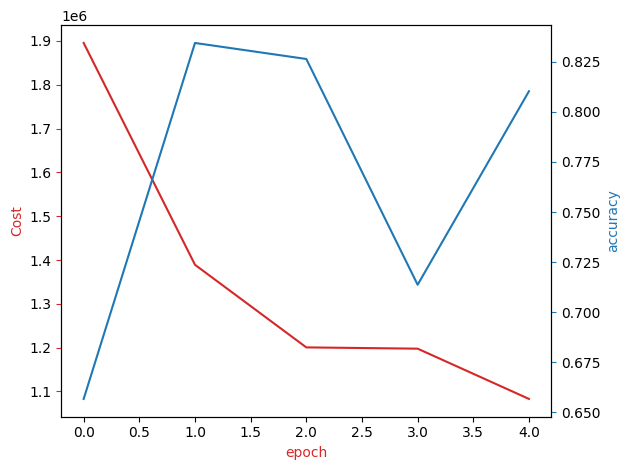

In [17]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.set_xlabel('epoch', color=color)
ax2.plot(accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()